In [8]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
import json

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_MLPenhance.pth'


In [9]:
# Define CustomMLP with more complexity
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=4, dropout_prob=0.3):
        super(CustomMLP, self).__init__()

        # Store the number of layers
        self.num_layers = num_layers

        # Define the first down and gate layers
        self.down1 = nn.Linear(input_dim, hidden_dim)
        self.gate1 = nn.Linear(input_dim, hidden_dim)

        # Create additional layers dynamically
        self.down_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)
        ])
        self.gate_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)
        ])

        # Add batch normalization for each layer
        self.batch_norm_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_dim) for _ in range(num_layers)
        ])

        # Add residual connection for each layer
        self.residual_connections = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim) if i == 0 else nn.Identity() 
            for i in range(num_layers)
        ])

        # Final output layer
        self.up = nn.Linear(hidden_dim, 1)

        # Activation function (Swish/SiLU)
        self.activation = nn.SiLU()

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # First layer with down/gate and residual connection
        down_output = self.down1(x)
        gate_output = self.gate1(x)
        gated_output = down_output * self.activation(gate_output)

        # Residual connection for first layer
        residual = self.residual_connections[0](x)
        gated_output = gated_output + residual

        # Apply batch normalization
        gated_output = self.batch_norm_layers[0](gated_output)

        # Process through additional layers
        for i in range(1, self.num_layers):
            down_output = self.down_layers[i - 1](gated_output)
            gate_output = self.gate_layers[i - 1](gated_output)
            gated_output = down_output * self.activation(gate_output)

            # Residual connection
            residual = self.residual_connections[i](gated_output)
            gated_output = gated_output + residual

            # Batch normalization
            gated_output = self.batch_norm_layers[i](gated_output)

            # Dropout regularization
            gated_output = self.dropout(gated_output)

        # Final output layer
        output = self.up(gated_output)
        return output

In [10]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=128):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[-1].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [11]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [12]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    print(f"Best Classification Report {report}")
    return custom_mlp, losses, best_accuracy

In [13]:
# def main for reference embedding/train
def main(model_name, non_infringement_file, infringement_file, checkpoint_path):
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
    model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
    tokenizer.pad_token = tokenizer.eos_token
    bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
    bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
    bert_tokenizer.pad_token = tokenizer.eos_token

    non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
        non_infringement_file, infringement_file
    )

    y_non_infringement = np.array(y_non_infringement)
    y_infringement = np.array(y_infringement)

    print("Extracting hidden states for non_infringement texts...")
    X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
    print("Extracting reference embeddings for non_infringement texts...")
    reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
    X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

    print("Extracting hidden states for infringement texts...")
    X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
    print("Extracting reference embeddings for infringement texts...")
    reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
    X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

    split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
    X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
    X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
    y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
    y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

    split_index_infringement = int(0.8 * len(X_infringement_combined))
    X_infringement_train = X_infringement_combined[:split_index_infringement]
    X_infringement_test = X_infringement_combined[split_index_infringement:]
    y_infringement_train = y_infringement[:split_index_infringement]
    y_infringement_test = y_infringement[split_index_infringement:]

    X_train = np.vstack((X_non_infringement_train, X_infringement_train))
    X_test = np.vstack((X_non_infringement_test, X_infringement_test))
    y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
    y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

    input_dim = X_train.shape[1]
    hidden_dim = 256 
    print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

    best_model, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 3/3 [05:17<00:00, 105.86s/it]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 3/3 [05:30<00:00, 110.28s/it]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epochs:   2%|▏         | 9/500 [00:00<00:31, 15.68it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

Epoch 10/500, Loss: 0.7175
Test Accuracy at Epoch 10: 55.56%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117

New best model saved with accuracy 55.56% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:   4%|▍         | 19/500 [00:01<00:31, 15.32it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 20/500, Loss: 0.7230
Test Accuracy at Epoch 20: 55.56%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:   6%|▌         | 29/500 [00:02<00:33, 14.09it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 30/500, Loss: 0.6890
Test Accuracy at Epoch 30: 55.56%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:   8%|▊         | 39/500 [00:02<00:33, 13.70it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 40/500, Loss: 0.7546
Test Accuracy at Epoch 40: 55.56%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  10%|▉         | 49/500 [00:03<00:30, 14.93it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 50/500, Loss: 0.7057
Test Accuracy at Epoch 50: 55.56%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  12%|█▏        | 59/500 [00:04<00:30, 14.63it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 60/500, Loss: 0.7020
Test Accuracy at Epoch 60: 55.56%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  14%|█▍        | 69/500 [00:04<00:33, 12.89it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 70/500, Loss: 0.6977
Test Accuracy at Epoch 70: 55.56%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  16%|█▌        | 79/500 [00:05<00:30, 13.94it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 80/500, Loss: 0.7048
Test Accuracy at Epoch 80: 55.56%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  18%|█▊        | 89/500 [00:06<00:28, 14.25it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 90/500, Loss: 0.6964
Test Accuracy at Epoch 90: 55.56%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  20%|█▉        | 99/500 [00:07<00:24, 16.45it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epoch 100/500, Loss: 0.7117
Test Accuracy at Epoch 100: 55.56%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  22%|██▏       | 109/500 [00:07<00:25, 15.36it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 110/500, Loss: 0.6874
Test Accuracy at Epoch 110: 55.56%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  24%|██▍       | 119/500 [00:08<00:25, 15.19it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 120/500, Loss: 0.7051
Test Accuracy at Epoch 120: 55.56%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  26%|██▌       | 129/500 [00:09<00:30, 12.10it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 130/500, Loss: 0.7035
Test Accuracy at Epoch 130: 55.56%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  28%|██▊       | 139/500 [00:09<00:23, 15.59it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 140/500, Loss: 0.6982
Test Accuracy at Epoch 140: 55.56%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  30%|██▉       | 149/500 [00:10<00:26, 13.09it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 150/500, Loss: 0.6964
Test Accuracy at Epoch 150: 55.56%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  32%|███▏      | 159/500 [00:11<00:22, 15.36it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 160/500, Loss: 0.6856
Test Accuracy at Epoch 160: 55.56%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  34%|███▍      | 169/500 [00:12<00:26, 12.70it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 170/500, Loss: 0.6986
Test Accuracy at Epoch 170: 55.56%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  36%|███▌      | 179/500 [00:12<00:19, 16.18it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 180/500, Loss: 0.7284
Test Accuracy at Epoch 180: 55.56%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  38%|███▊      | 189/500 [00:13<00:19, 15.85it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 190/500, Loss: 0.6895
Test Accuracy at Epoch 190: 55.56%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  40%|███▉      | 199/500 [00:14<00:20, 14.49it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 200/500, Loss: 0.7081
Test Accuracy at Epoch 200: 55.56%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  42%|████▏     | 209/500 [00:14<00:17, 16.92it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 210/500, Loss: 0.6983
Test Accuracy at Epoch 210: 55.56%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  44%|████▍     | 219/500 [00:15<00:18, 14.85it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 220/500, Loss: 0.7027
Test Accuracy at Epoch 220: 55.56%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  46%|████▌     | 229/500 [00:16<00:18, 14.62it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 230/500, Loss: 0.6869
Test Accuracy at Epoch 230: 55.56%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  48%|████▊     | 239/500 [00:16<00:16, 16.27it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 240/500, Loss: 0.6847
Test Accuracy at Epoch 240: 55.56%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  50%|████▉     | 249/500 [00:17<00:15, 15.86it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 250/500, Loss: 0.7049
Test Accuracy at Epoch 250: 55.56%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  52%|█████▏    | 259/500 [00:18<00:18, 13.29it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 260/500, Loss: 0.6934
Test Accuracy at Epoch 260: 55.56%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  54%|█████▍    | 269/500 [00:18<00:13, 16.83it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 270/500, Loss: 0.6822
Test Accuracy at Epoch 270: 55.56%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  56%|█████▌    | 279/500 [00:19<00:17, 12.57it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 280/500, Loss: 0.6936
Test Accuracy at Epoch 280: 55.56%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  58%|█████▊    | 289/500 [00:20<00:13, 15.43it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 290/500, Loss: 0.6855
Test Accuracy at Epoch 290: 55.56%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  60%|█████▉    | 299/500 [00:20<00:11, 16.87it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 300/500, Loss: 0.6949
Test Accuracy at Epoch 300: 55.56%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  62%|██████▏   | 309/500 [00:21<00:12, 15.08it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 310/500, Loss: 0.6923
Test Accuracy at Epoch 310: 55.56%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  64%|██████▍   | 319/500 [00:22<00:11, 15.78it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 320/500, Loss: 0.6926
Test Accuracy at Epoch 320: 55.56%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  66%|██████▌   | 329/500 [00:22<00:12, 13.89it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 330/500, Loss: 0.6908
Test Accuracy at Epoch 330: 55.56%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  68%|██████▊   | 339/500 [00:23<00:09, 16.13it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 340/500, Loss: 0.6890
Test Accuracy at Epoch 340: 55.56%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  70%|██████▉   | 349/500 [00:24<00:10, 14.83it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 350/500, Loss: 0.6889
Test Accuracy at Epoch 350: 55.56%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  72%|███████▏  | 359/500 [00:24<00:08, 15.97it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 360/500, Loss: 0.6949
Test Accuracy at Epoch 360: 55.56%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  74%|███████▍  | 369/500 [00:25<00:09, 13.92it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 370/500, Loss: 0.6914
Test Accuracy at Epoch 370: 55.56%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  76%|███████▌  | 379/500 [00:26<00:07, 16.35it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 380/500, Loss: 0.6811
Test Accuracy at Epoch 380: 55.56%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  78%|███████▊  | 389/500 [00:27<00:08, 13.75it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 390/500, Loss: 0.6886
Test Accuracy at Epoch 390: 55.56%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  80%|███████▉  | 399/500 [00:27<00:06, 15.78it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 400/500, Loss: 0.6843
Test Accuracy at Epoch 400: 55.56%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  82%|████████▏ | 409/500 [00:28<00:07, 11.58it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 410/500, Loss: 0.6880
Test Accuracy at Epoch 410: 55.56%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  84%|████████▍ | 419/500 [00:29<00:05, 15.59it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 420/500, Loss: 0.6893
Test Accuracy at Epoch 420: 55.56%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  86%|████████▌ | 429/500 [00:29<00:05, 12.38it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 430/500, Loss: 0.6885
Test Accuracy at Epoch 430: 55.56%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  88%|████████▊ | 439/500 [00:30<00:04, 14.88it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 440/500, Loss: 0.6859
Test Accuracy at Epoch 440: 55.56%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  90%|████████▉ | 449/500 [00:31<00:03, 16.81it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 450/500, Loss: 0.6830
Test Accuracy at Epoch 450: 55.56%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  92%|█████████▏| 459/500 [00:31<00:02, 15.36it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 460/500, Loss: 0.6849
Test Accuracy at Epoch 460: 55.56%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  94%|█████████▍| 469/500 [00:32<00:02, 15.30it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 470/500, Loss: 0.6843
Test Accuracy at Epoch 470: 55.56%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  96%|█████████▌| 479/500 [00:33<00:01, 15.33it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 480/500, Loss: 0.6822
Test Accuracy at Epoch 480: 55.56%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs:  98%|█████████▊| 489/500 [00:33<00:00, 15.96it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 490/500, Loss: 0.6855
Test Accuracy at Epoch 490: 55.56%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



Training Epochs: 100%|█████████▉| 499/500 [00:34<00:00, 13.67it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Epoch 500/500, Loss: 0.6905
Test Accuracy at Epoch 500: 55.56%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



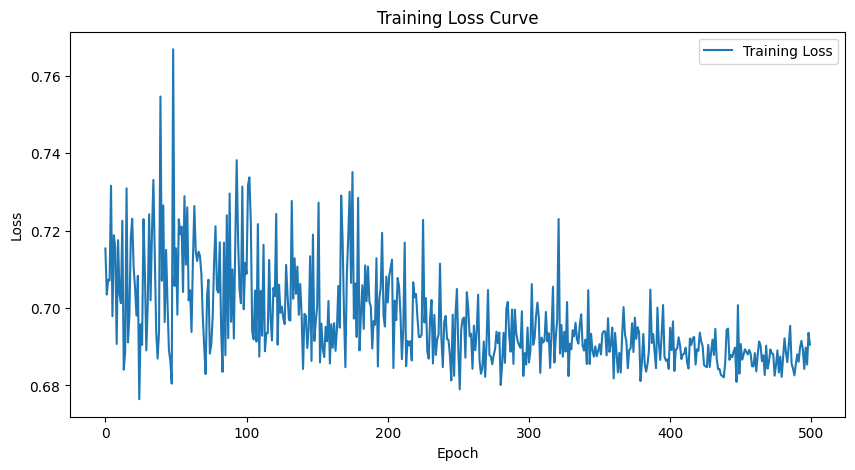

Best Model was saved at epoch 10 with accuracy 55.56%
Best Classification Report                   precision    recall  f1-score   support

    infringement       0.56      1.00      0.71        65
non_infringement       0.00      0.00      0.00        52

        accuracy                           0.56       117
       macro avg       0.28      0.50      0.36       117
    weighted avg       0.31      0.56      0.40       117



In [14]:

# Run main
main(model_name, non_infringement_file, infringement_file, checkpoint_file)
